# Предсказание последовательности ДНК

Есть последовательность ДНК. Как известно, она состоит из букв A, C, T, G. В биоинформатике есть такая задача - предсказывать недостающие данные (пропуски) в последовательности генов. Например, есть пропуск в последовательности. Знаем, что есть 5-30 известных символов слева, 5-30 известных символов - справа от этого пропуска.

* Ваша задача - написать код, который позволяет подготовить данные модели на обучение, а также саму модель с необходимыми метриками.
* Как будут входные данные подаваться на вход - на ваше усмотрение.

**Замечание.**

В некоторых строках вначале стоят буквы N - от них можно избавиться. 
Строки, в которых содержаться символы, кроме TCGA можно не использовать.

# Импорт библиотек и загрузка данных

In [1]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import seaborn as sns
import regex as re
import zipfile
from collections import Counter

from tqdm import tqdm, notebook
tqdm.pandas(desc='Progress bar ')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric

Произведем выгрузку.

In [2]:
try:
    df = pq.read_table(source='dna.parquet').to_pandas()
except:
    
    # Прочтем файл.
    lines = []
    with zipfile.ZipFile('mart_export.zip', 'r').open('mart_export.txt') as f:
        for line in f:
            filtered_line = line.decode("utf-8").strip()
            if(filtered_line == ''):
                continue
            if(filtered_line[0] == '>'):
                filtered_line = filtered_line[1:] + '|'
                lines.append(filtered_line)
            else:
                try:
                    match = re.fullmatch(r'[TCGA_]+', filtered_line.strip('N'))
                    lines[-1] += match[0]
                except:
                    None
    
    # Сформируем датафрейм. Удалим NaN (Sequence unavailable и строки, содержащие символы, кроме TCGA) в последовательности.
    df = pd.DataFrame([line.split('|') for line in lines])
    df.columns= ['code1', 'code2', 'code3', 'code4', 'sequence']
    
    # Удалим объекты, в которых последовательность короче 11 символов, руководствуясь условиями задачи.
    df = df.where(df['sequence'].map(len) > 10).dropna()
    df = df.reset_index(drop=True)
    
    # Сохраним результат обработки.
    df.to_parquet('dna.parquet')

df.head()

,code1,code2,code3,code4,sequence
0,ENSG00000004776,ENSG00000004776.13,ENST00000004982,ENST00000004982.6,ATGGAGATCCCTGTGCCTGTGCAGCCGTCTTGGCTGCGCCGCGCCT...
1,ENSG00000001626,ENSG00000001626.15,ENST00000003084,ENST00000003084.10,ATGCAGAGGTCGCCTCTGGAAAAGGCCAGCGTTGTCTCCAAACTTT...
2,ENSG00000001461,ENSG00000001461.17,ENST00000003912,ENST00000003912.7,ATGCTTCTGGGCGAGCTGGGTGTGTTCGCCTCCTACGCCTTCGCGC...
3,ENSG00000001036,ENSG00000001036.14,ENST00000002165,ENST00000002165.11,ATGCGGCCCCAGGAGCTCCCCAGGCTCGCGTTCCCGTTGCTGCTGT...
4,ENSG00000003137,ENSG00000003137.8,ENST00000001146,ENST00000001146.6,ATGCTCTTTGAGGGCTTGGATCTGGTGTCGGCGCTGGCCACCCTCG...


Сформируем датафрейм отбросив неиспользуемые признаки.

In [3]:
sequence_df = df['sequence'].copy()
print(sequence_df.shape)
sequence_df.head()

(110720,)


0    ATGGAGATCCCTGTGCCTGTGCAGCCGTCTTGGCTGCGCCGCGCCT...
1    ATGCAGAGGTCGCCTCTGGAAAAGGCCAGCGTTGTCTCCAAACTTT...
2    ATGCTTCTGGGCGAGCTGGGTGTGTTCGCCTCCTACGCCTTCGCGC...
3    ATGCGGCCCCAGGAGCTCCCCAGGCTCGCGTTCCCGTTGCTGCTGT...
4    ATGCTCTTTGAGGGCTTGGATCTGGTGTCGGCGCTGGCCACCCTCG...
Name: sequence, dtype: object

Очевидно, что последовательности будут повторятся. Визуализируем как их длина влияет на количество дубликатов.

* Обнаружен резкий переход после того, как длина последовательности становится выше 10 символов.
* Для оптимизации времени расчетов будет использовать длину последовательности равную 11 (10 признаков + таргет).

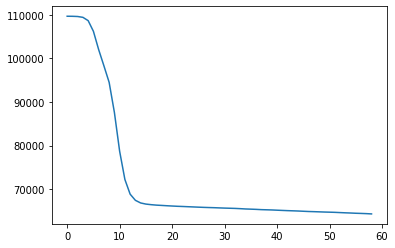

In [4]:
duplicates = []
for i in range(1, 60, 1):
    duplicates.append(
        sequence_df[sequence_df.map(len) > 60].map(lambda x: x[:i]).duplicated().sum()
    )
    
sns.lineplot(data=duplicates);

# Решение с использованием регулярных выражений

Функция поиска.

In [5]:
def prediction(x, s, i, j):
    # Глубина пропуска.
    gap = s.count('_')
    # Разделение строки.
    arr = s.split('_')
    try:
        m = re.match(fr'.+ {arr[0][-i:]} (?P<match>.{{{gap}}}) {arr[-1][:j]} .+', x, re.X)
        return m['match']
    except:
        return None

Запустим алгоритм поиска совпадений нашей последовательности с теми, что есть базе.

В результате получаем пропущенный ген и вероятность оценки.

In [6]:
def re_predict(df, sequences):
    result = {
        'prediction': [],
        'proba': []
    }

    for s in sequences:
        i = j = 30
        
        # Начальные значения. Вместо 'А' можно было задать 'error’ на случай, если совпадений совсем нет
        # и даже последовательность минимальной длины уникальна.
        missed_gen ='A'
        prob = 0
        prob_last = 0
        
        # Количество известных символов.
        while(i + j > 5):
            d = Counter(
                df.map(lambda x: prediction(x, s, i, j)).dropna()
            )
            
            # Обновляем missed_gen и prob если есть совпадения.
            try:
                missed_gen = sorted(d.items(), key=lambda x: x[1])[0][0]
                prob = d[missed_gen] / sum(d.values())
            except:
                None

            if(i >= j):
                j -= 1
            else:
                i -= 1
                
            # Важное условие чтобы вовремя остановится иначе подбор продолжится и будет
            # выбран ген с более высокой вероятностью, но для меньшей последовательности.
            if prob >= prob_last:
                break
        
        result['prediction'].append(missed_gen)
        result['proba'].append(prob)
        
    return result

Смоделируем пропуски в последовательности и найдем их, используя функцию re_predict.

In [7]:
X_test = sequence_df[(sequence_df.map(len) > 250) & (sequence_df.map(len) < 5000)].sample(1000, random_state=38).apply(lambda x: x[:123] + '_' + x[124:])
y_test = sequence_df[(sequence_df.map(len) > 250) & (sequence_df.map(len) < 5000)].sample(1000, random_state=38).apply(lambda x: x[123])

# Для тренировочного набора используем объекты с противоположным индексом.
train = sequence_df[~sequence_df.index.isin(X_test.index)]

print(train.shape, X_test.shape)

(109720,) (1000,)


Более низкий precision у класса А объясняется тем, что все уникальные последовательности мы отправляем в него.

In [8]:
y_hat = re_predict(train, X_test.values)
print(classification_report(y_test, y_hat['prediction']))

              precision    recall  f1-score   support

           A       0.77      1.00      0.87       235
           C       1.00      0.92      0.96       241
           G       1.00      0.91      0.95       325
           T       1.00      0.89      0.94       199

    accuracy                           0.93      1000
   macro avg       0.94      0.93      0.93      1000
weighted avg       0.95      0.93      0.93      1000



Алгоритм получил отличный результат, он почти не требует подготовки данных и не имеет ограничения на глубину пропусков.

# ML решение с CatBoost

## Подготовка данных. Разделение на признаки и таргет

Вспомогательные функции для выделения признаков и целевой переменной.

In [9]:
def c_left(x, i):
    try:
        return x[i:i+5]
    except:
        return np.nan

def c_right(x, i):
    try:
        if len(x[i+6:i+11]) == 5:
            return x[i+6:i+11]
        else:
            return np.nan
    except:
        return np.nan

def c_target(x, i):
    try:
        return x[i+5]
    except:
        return np.nan

In [10]:
sequence_lists = []

for i in notebook.tqdm(range(500)):
    df = pd.concat([sequence_df.map(lambda x: c_left(x, i)),
                    sequence_df.map(lambda x: c_right(x, i)),
                    sequence_df.map(lambda x: c_target(x, i))
                   ], axis=1)
    sequence_lists.append(df)
    
prepared_data = np.concatenate(sequence_lists)

  0%|          | 0/500 [00:00<?, ?it/s]

Оставим только объеты без пропусков.

In [11]:
prepared_data = prepared_data[(~pd.isna(prepared_data)).all(axis=1)]
print(prepared_data.shape)
prepared_data

(46376195, 3)


array([['ATGGA', 'ATCCC', 'G'],
       ['ATGCA', 'AGGTC', 'G'],
       ['ATGCT', 'CTGGG', 'T'],
       ...,
       ['AAGTA', 'AACAA', 'C'],
       ['GGACA', 'CCAAG', 'T'],
       ['ATCCA', 'TGGAT', 'G']], dtype=object)

## Модель

Оценим сбалансированность классов.

In [12]:
unique, counts = np.unique(prepared_data[:, 2], return_counts=True)

dict(zip(unique, counts))

{'A': 11620609, 'C': 12160295, 'G': 12544311, 'T': 10050980}

Подготовим pool'ы для CatBoostClassifier.

In [13]:
# Ограничение по данным, обусловленное вычислительной мощностью системы.
limit = 1000000

X = prepared_data[:limit,:2]
y = prepared_data[:limit,2]

X_train, X_eval, y_train, y_eval = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=38)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=38)

train_pool = Pool(X_train, y_train, cat_features=[0,1])
eval_pool = Pool(X_eval, y_eval, cat_features=[0,1])

In [14]:
# Гиперпараметры.
params = {
    'loss_function': 'MultiClass',
    'eval_metric': 'HammingLoss',
    # 'task_type': 'GPU',
    # 'devices': '0:1',
    'learning_rate': 0.1,
    'iterations': 200,
    'class_names': ['G', 'A', 'T', 'C']
}

cb = CatBoostClassifier(random_state=38, **params)
cb.fit(train_pool,
       eval_set=eval_pool,
       plot=True,
       verbose=100);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3567938	test: 0.2734100	best: 0.2734100 (0)	total: 601ms	remaining: 1m 59s
100:	learn: 0.3413296	test: 0.2632600	best: 0.2628700 (72)	total: 35.4s	remaining: 34.7s
199:	learn: 0.3398988	test: 0.2628100	best: 0.2627600 (180)	total: 1m 9s	remaining: 0us

bestTest = 0.26276
bestIteration = 180

Shrink model to first 181 iterations.


Результат во многом зависит от количества последовательностей, которые нам доступны. С их ростом, точность должна будет возрастать.

In [15]:
y_hat = cb.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           A       0.75      0.71      0.73     21280
           C       0.74      0.75      0.75     24494
           G       0.72      0.79      0.75     26033
           T       0.76      0.68      0.72     18193

    accuracy                           0.74     90000
   macro avg       0.74      0.73      0.74     90000
weighted avg       0.74      0.74      0.74     90000



# Выводы

* Подготовлены дынные, сформированы признаки и таргет.
* Создана модель с необходимыми метриками. Проведена её валидация.